In [131]:
!pip install gdown

In [25]:
!gdown https://drive.google.com/uc?id=12Uk6cECvvLJkS6SS4xJK3S_AxbsIAel1

Downloading...
From: https://drive.google.com/uc?id=12Uk6cECvvLJkS6SS4xJK3S_AxbsIAel1
To: /content/train_meta.pkl
743MB [00:03, 238MB/s]


In [0]:
!mkdir data
!mv train_meta.pkl data/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import path
import re
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_log_error
import pickle
from sklearn.externals import joblib

from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.optimizers import Adam
from datetime import timedelta

from WikiPlot import *
from PerformanceMetrics import *

/Users/maximelovino/Documents/LOCAL_CODE/WikiForecasting/venv/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.


In [2]:
root_folder = "./data"
train_file = path.join(root_folder,"train_meta.pkl")
df = pd.read_pickle(train_file)
df.head()

,name,lang,access,agent,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,588.0,7.0,0.0,1.0,18.0,11.0,5.0,13.0,14.0,9.0,...,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0
1,589.0,7.0,0.0,1.0,11.0,14.0,15.0,18.0,11.0,13.0,...,32.0,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0,81.0
2,643.0,7.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,4.0,...,6.0,6.0,7.0,2.0,4.0,7.0,3.0,4.0,7.0,6.0
3,683.0,7.0,0.0,1.0,35.0,13.0,10.0,94.0,4.0,26.0,...,7.0,19.0,19.0,9.0,6.0,16.0,19.0,30.0,38.0,4.0
4,699.0,7.0,0.0,1.0,12.0,7.0,4.0,5.0,20.0,8.0,...,13.0,13.0,45.0,4.0,13.0,20.0,18.0,17.0,14.0,11.0


In [3]:
meta = df.iloc[:,:4]
df = df.iloc[:,4:]
df.head()

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,24.0,...,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0
1,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,4.0,...,32.0,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0,81.0
2,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,4.0,...,6.0,6.0,7.0,2.0,4.0,7.0,3.0,4.0,7.0,6.0
3,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,16.0,...,7.0,19.0,19.0,9.0,6.0,16.0,19.0,30.0,38.0,4.0
4,12.0,7.0,4.0,5.0,20.0,8.0,5.0,17.0,24.0,7.0,...,13.0,13.0,45.0,4.0,13.0,20.0,18.0,17.0,14.0,11.0


In [4]:
meta.head()

,name,lang,access,agent
0,588.0,7.0,0.0,1.0
1,589.0,7.0,0.0,1.0
2,643.0,7.0,0.0,1.0
3,683.0,7.0,0.0,1.0
4,699.0,7.0,0.0,1.0


In [5]:
data_start_date = df.columns[0]
data_end_date = df.columns[-1]
print('Data ranges from %s to %s' % (data_start_date, data_end_date))

Data ranges from 2015-07-01 to 2017-09-10


In [6]:
pred_steps = 60
pred_length=timedelta(pred_steps)

first_day = pd.to_datetime(data_start_date) 
last_day = pd.to_datetime(data_end_date)

val_pred_start = last_day - pred_length + timedelta(1)
val_pred_end = last_day

train_pred_start = val_pred_start - pred_length
train_pred_end = val_pred_start - timedelta(days=1)

In [7]:
enc_length = train_pred_start - first_day

train_enc_start = first_day
train_enc_end = train_enc_start + enc_length - timedelta(1)

val_enc_start = train_enc_start + pred_length
val_enc_end = val_enc_start + enc_length - timedelta(1)

In [8]:
print('Train encoding:', train_enc_start, '-', train_enc_end)
print('Train prediction:', train_pred_start, '-', train_pred_end, '\n')
print('Val encoding:', val_enc_start, '-', val_enc_end)
print('Val prediction:', val_pred_start, '-', val_pred_end)

print('\nEncoding interval:', enc_length.days)
print('Prediction interval:', pred_length.days)

Train encoding: 2015-07-01 00:00:00 - 2017-05-13 00:00:00
Train prediction: 2017-05-14 00:00:00 - 2017-07-12 00:00:00 

Val encoding: 2015-08-30 00:00:00 - 2017-07-12 00:00:00
Val prediction: 2017-07-13 00:00:00 - 2017-09-10 00:00:00

Encoding interval: 683
Prediction interval: 60


In [9]:
date_to_index = pd.Series(index=pd.Index([pd.to_datetime(c) for c in df.columns[0:]]),
                          data=[i for i in range(len(df.columns[0:]))])

series_array = df.values

def get_time_block_series(series_array, date_to_index, start_date, end_date):
    
    inds = date_to_index[start_date:end_date]
    return series_array[:,inds]

def transform_series_encode(series_array):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_mean = series_array.mean(axis=1).reshape(-1,1) 
    series_array = series_array - series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array, series_mean

def transform_series_decode(series_array, encode_series_mean):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_array = series_array - encode_series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array

In [10]:


latent_dim = 50 # LSTM hidden units
dropout = .20 

# Define an input series and encode it with an LSTM. 
encoder_inputs = Input(shape=(None, 1)) 
encoder = LSTM(latent_dim, dropout=dropout, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the final states. These represent the "context"
# vector that we use as the basis for decoding.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
# This is where teacher forcing inputs are fed in.
decoder_inputs = Input(shape=(None, 1)) 

# We set up our decoder using `encoder_states` as initial state.  
# We return full output sequences and return internal states as well. 
# We don't use the return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, dropout=dropout, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)

decoder_dense = Dense(1) # 1 continuous output at each timestep
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [11]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 1)      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 1)      0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 50), (None,  10400       input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, None, 50), ( 10400       input_2[0][0]                    
                                                                 lstm_1[0][1]                     
          

In [12]:
first_n_samples = 5000
batch_size = 2**11
epochs = 10

# sample of series from train_enc_start to train_enc_end  
encoder_input_data = get_time_block_series(series_array, date_to_index, 
                                           train_enc_start, train_enc_end)[:first_n_samples]
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

# sample of series from train_pred_start to train_pred_end 
decoder_target_data = get_time_block_series(series_array, date_to_index, 
                                            train_pred_start, train_pred_end)[:first_n_samples]
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

# lagged target series for teacher forcing
decoder_input_data = np.zeros(decoder_target_data.shape)
decoder_input_data[:,1:,0] = decoder_target_data[:,:-1,0]
decoder_input_data[:,0,0] = encoder_input_data[:,-1,0]

model.compile(Adam(), loss='mean_absolute_error')
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
                     batch_size=batch_size,
                     epochs=epochs,
                     validation_split=0.2)

Instructions for updating:
Use tf.cast instead.
Train on 4000 samples, validate on 1000 samples
Epoch 1/10
4000/4000 [==============================] - 12s 3ms/step - loss: 0.4654 - val_loss: 0.5250
Epoch 2/10
4000/4000 [==============================] - 8s 2ms/step - loss: 0.4424 - val_loss: 0.5066
Epoch 3/10
4000/4000 [==============================] - 8s 2ms/step - loss: 0.4212 - val_loss: 0.4887
Epoch 4/10
4000/4000 [==============================] - 9s 2ms/step - loss: 0.4029 - val_loss: 0.4713
Epoch 5/10
4000/4000 [==============================] - 9s 2ms/step - loss: 0.3885 - val_loss: 0.4546
Epoch 6/10
4000/4000 [==============================] - 10s 2ms/step - loss: 0.3768 - val_loss: 0.4375
Epoch 7/10
4000/4000 [==============================] - 11s 3ms/step - loss: 0.3739 - val_loss: 0.4185
Epoch 8/10
4000/4000 [==============================] - 11s 3ms/step - loss: 0.3746 - val_loss: 0.3990
Epoch 9/10
4000/4000 [==============================] - 11s 3ms/step - loss: 0.3735 

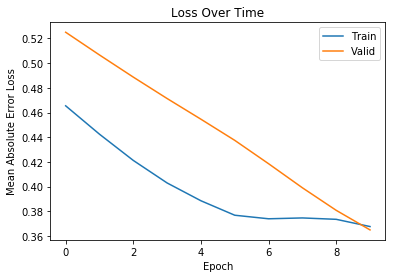

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [14]:
# from our previous model - mapping encoder sequence to state vectors
encoder_model = Model(encoder_inputs, encoder_states)

# A modified version of the decoding stage that takes in predicted target inputs
# and encoded state vectors, returning predicted target outputs and decoder state vectors.
# We need to hang onto these state vectors to run the next step of the inference loop.
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]

decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs,
                      [decoder_outputs] + decoder_states)

def decode_sequence(input_seq, target, truth):
    
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, 1))
    
    # Populate the first target sequence with end of encoding series pageviews
    target_seq[0, 0, 0] = input_seq[0, -1, 0]

    # Sampling loop for a batch of sequences - we will fill decoded_seq with predictions
    # (to simplify, here we assume a batch of size 1).

    decoded_seq = np.zeros((1,pred_steps,1))
    
    for i in range(pred_steps):
        
        output, h, c = decoder_model.predict([target_seq] + states_value)
        
        decoded_seq[0,i,0] = output[0,0,0]

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, 1))
        if truth:
            target_seq[0, 0, 0] = target[i][0]
        else:
            target_seq[0, 0, 0] = output[0,0,0]

        # Update states
        states_value = [h, c]

    return decoded_seq

In [15]:
encoder_input_data = get_time_block_series(series_array, date_to_index, val_enc_start, val_enc_end)
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

decoder_target_data = get_time_block_series(series_array, date_to_index, val_pred_start, val_pred_end)
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

In [16]:
def denormalizeSeries(series, means, sample_ind):
  new_series = series + means[sample_ind,0]
  new_series = np.expm1(new_series)
  return new_series

In [21]:
def predict_and_plot(encoder_input_data, decoder_target_data, sample_ind, means, enc_tail_len=50, truth=False):
    encode_series = encoder_input_data[sample_ind:sample_ind+1,:,:] 
    
    target_series = decoder_target_data[sample_ind,:,:1].reshape(-1,1)
    pred_series = decode_sequence(encode_series,target_series, truth)
    
    encode_series = encode_series.reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)  
    pred_series = denormalizeSeries(pred_series,means,sample_ind)
    encode_series = denormalizeSeries(encode_series,means,sample_ind)
    target_series = denormalizeSeries(target_series,means,sample_ind)
    
    plot_prediction(encode_series,target_series,pred_series,enc_tail_len)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


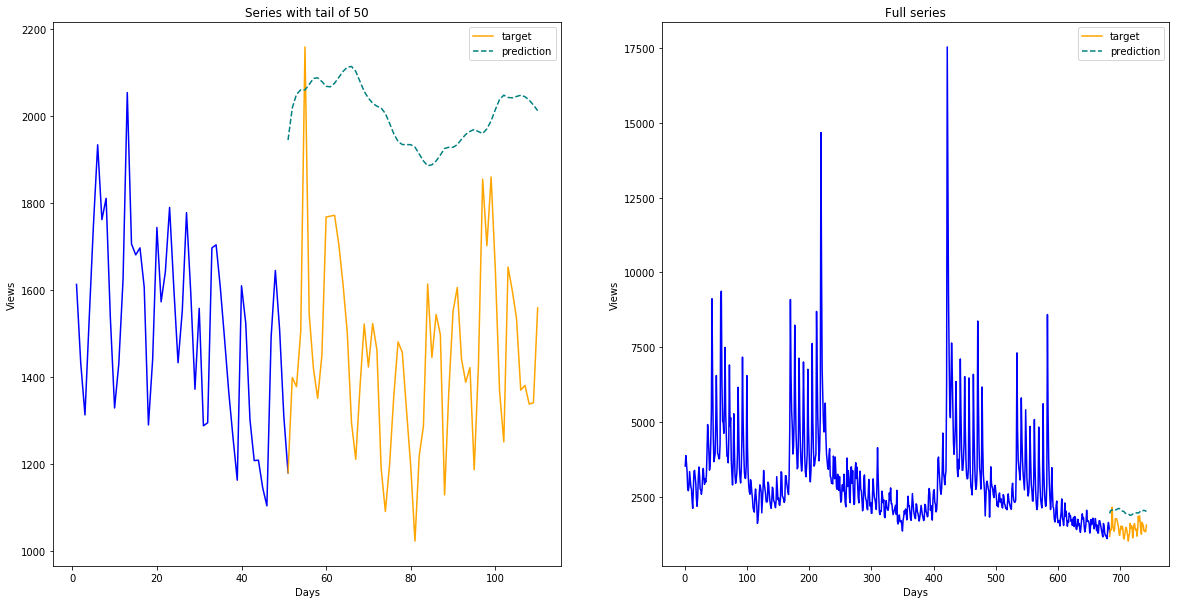

In [22]:
predict_and_plot(encoder_input_data, decoder_target_data, 6006, encode_series_mean, truth=True)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


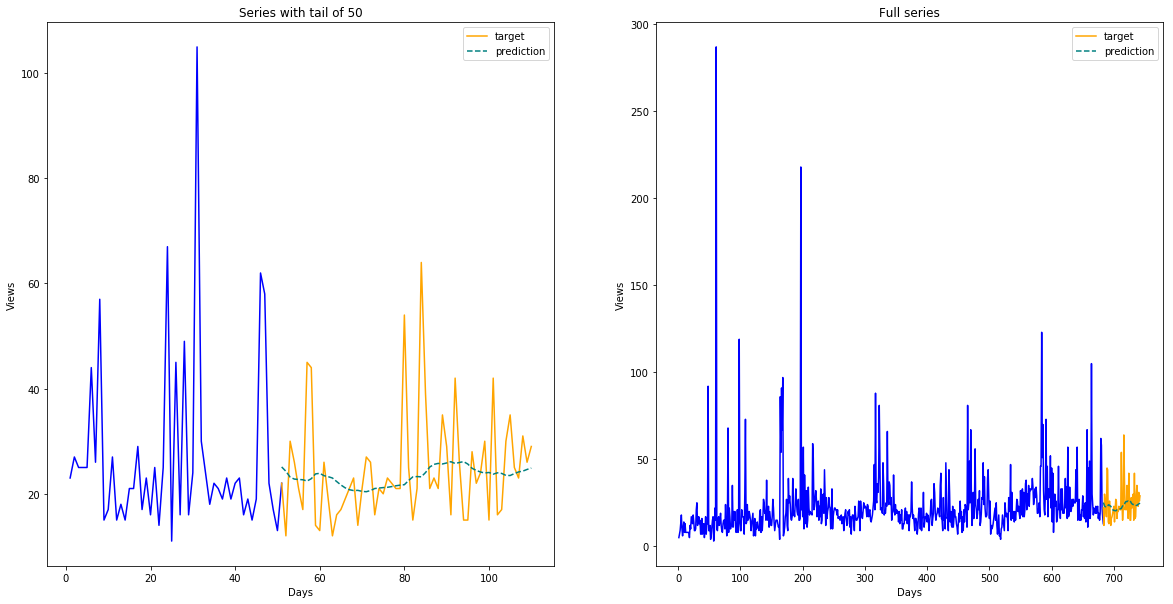

In [23]:
predict_and_plot(encoder_input_data, decoder_target_data, 2000, encode_series_mean, truth=True)

In [0]:
errors_truth = []
errors_standard = []
for i in np.random.choice(encoder_input_data.shape[0],100):
    encode_series = encoder_input_data[i:i+1,:,:] 
    target_series = decoder_target_data[i,:,:1].reshape(-1,1)
    pred_series_truth = decode_sequence(encode_series,target_series, True)
    pred_series_truth = pred_series_truth.reshape(-1,1) 

    
    pred_series_standard = decode_sequence(encode_series,target_series, False)
    pred_series_standard = pred_series_standard.reshape(-1,1) 
    
    pred_series_standard = denormalizeSeries(pred_series_standard,encode_series_mean,i)
    pred_series_truth = denormalizeSeries(pred_series_truth,encode_series_mean,i)
    target_series = denormalizeSeries(target_series,encode_series_mean,i)
    
    errors_truth.append(smape(target_series,pred_series_truth))
    errors_standard.append(smape(target_series,pred_series_standard))

In [193]:
np.array(errors_truth).mean()

28.912080993008168

In [194]:
np.array(errors_standard).mean()

39.628938358755796